# Multi-armedBandits - Chapter 2

## A k-armed Bandit Problem
Bandit problem is a simplified setting for reinforcement learning in which you are faced repeatedly with a choice among k different options (actions).After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total
reward over some time period, for example, over 1000 action selections, or time steps.


In our k-armed bandit problem, each of the k actions has an expected or mean reward given that
that action is selected; let us call this the value of that action. We denote the action selected on time
step t as At , and the corresponding reward as Rt . The value then of an arbitrary **action a**, denoted
q∗ (a), is the **expected reward** given that a is selected:
$$q_{*}(a) = E \{ \ R_t \ | \ A_t=a \} $$

If you knew the value of each action, then it would be trivial to solve the k-armed bandit problem: you
would always select the action with highest value. We assume that you do not know the action values
with certainty, although you may have estimates. We denote the **estimated value** of action a at time
step t as ** $Q_t(a)$ **. We would like $Q_t(a)$ to be close to $q_∗$(a).

If you maintain estimates of the action values, then at any time step there is at least one action whose
estimated value is greatest. We call these the **greedy actions**. When you select one of these actions,
we say that you are **exploiting** your current knowledge of the values of the actions. If instead you
select one of the nongreedy actions, then we say you are **exploring**, because this enables you to improve
your estimate of the nongreedy action’s value. 

**Exploitation** $\to$ Maximize the expected reward on the **one step**.

**Exploration** $\to$ Produce the greater total reward in the **long run**.

Whether it is better to explore or exploit depends in a complex way on the precise values of the estimates, uncertainties, and the number of remaining steps.

## Action-value Methods
We begin by looking more closely at some simple methods for estimating the values of actions and for using the estimates to make action selection decisions. Recall that the true value of an action is the mean reward when that action is selected. One natural way to estimate this is by **averaging the rewards** actually received:
$$ Q_t(a) = \frac{sum \ of \ rewards\ when \ a \ taken \ prior \ to \ t}{number \ of \ times \ a \ taken \ prior \ to \ t} = \frac{\sum_{i=1}^{t-1}R_i \ . \ 1_{A_i=a}}{\sum_{i=1}^{t-1} 1_{A_i=a}}$$

*$1_{predicate}$ denotes the random variable that is 1 if predicate is true and 0 if it is not.*

We call this the **sample-average** method for **estimating action values**. Of course this is just one way to estimate action values, and not necessarily the best one.

The simplest action selection rule is to select **one of the actions** with the **highest estimated value**,
that is, one of the greedy actions as defined in the previous section. If there is **more than one greedy
action**, then a selection is made among them in some arbitrary way, perhaps **randomly**. We write this
greedy action selection method as:
$$A_t = argmax \ Q_t(a)$$
A simple alternative is to behave **greedily most of the time**, but every once in a while, say with small
**probability ε**, instead **select randomly from among all the actions** with equal probability, independently
of the action-value estimates. We call methods using this near-greedy action selection rule **ε-greedy**
methods.



In [1]:
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>


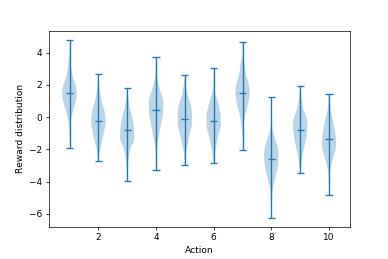

Text(0,0.5,'Reward distribution')

In [7]:
#Figure 2.1
%matplotlib notebook

#a sample from normal distribution with mean zero and unit variance for each action
q_star_value = np.random.randn(10) 
# a mean q_star_value, unit variance normal distribution
rewards = np.random.randn(500,10) + q_star_value 
plt.violinplot(dataset=rewards , showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")

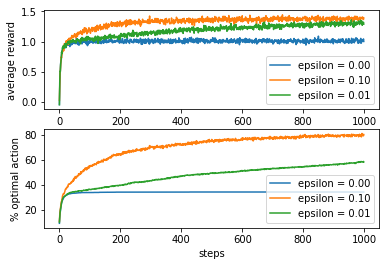

In [3]:
#Figure 2.2
k = 10
actions_count = np.zeros(k)
q_estimation = np.zeros(k)
q_true_value = np.random.randn(k)  # a sample from normal distribution with mean zero and unit variance for each action

def choose_action_epsilon_greedy(epsilon):
    global k
    global q_estimation

    if np.random.rand() < epsilon:
        return np.random.choice(np.arange(k))  # chose one of the arms randomly
    return np.argmax(q_estimation)


def step_epsilon_greedy(action):
    global q_true_value
    global actions_count
    global q_estimation

    # generate reward from a from normal distribution with mean q_true_value of that action and unit variance
    reward = np.random.randn() + q_true_value[action]
    
    actions_count[action] += 1

    # update estimation using sample averages
    q_estimation[action] += (reward - q_estimation[action]) / actions_count[action]

    return reward


def simulate_epsilon_greedy(runs, time_steps, epsilons):
    global k
    global q_true_value
    global actions_count
    global q_estimation

    best_action_counts = np.zeros((len(epsilons), runs, time_steps))
    rewards = np.zeros((len(epsilons), runs, time_steps))

    for i, eps in enumerate(epsilons):
        for r in range(runs):
            q_true_value = np.random.randn(k)
            q_estimation = np.zeros(k)
            actions_count = np.zeros(k)
            for t in range(time_steps):
                action = choose_action_epsilon_greedy(eps)
                reward = step_epsilon_greedy(action)
                rewards[i, r, t] = reward
                if action == np.argmax(q_true_value):
                    # it was the best action
                    best_action_counts[i, r, t] = 1
    
    # mean of all rewards and best action of all runs count in a particular time step and for a specific epsiolon
    best_action_counts = best_action_counts.mean(axis=1) 
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards


epsilons = [0, 0.1, 0.01]

best_action_counts, rewards = simulate_epsilon_greedy(2000, 1000, epsilons)

%matplotlib inline
plt.figure()

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts*100, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()



## Incremental Implementation
The action-value methods we have discussed so far all estimate action values as sample
averages of observed rewards. We now turn to the question of how these averages can be
computed in a computationally **efficient** manner, in particular, with **constant memory**
and constant per-time-step computation.

$$Q_n \ = \ \frac{R_1 \ + R_2 \ + \ ... \ + \ R_{n-1}}{n-1}$$

$$Q_{n+1} \ = \ \frac{1}{n} \ \sum_{i=1}^{n} \ R_i$$

$$ = \ \frac{1}{n} \ (R_n \ + \ \sum_{i=1}^{n-1} \ R_i )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ (n-1) \ \frac{1}{n-1} \ \sum_{i=1}^{n-1} \ R_i \ )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ (n-1) \ Q_n \ )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ n Q_n \ - \ Q_n \ )$$

$$ = \ Q_n \ + \ \frac{1}{n} \ [ \ R_n \ - \ Q_n \ ]$$

**NewEstimate <- OldEstimate + StepSize \[ Target - OldEstimatei \]**


## Tracking a Nonstationary Problem
Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the $q_*$(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the $q_*$(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\epsilon$ = 0.1 and longer runs, say of 10,000 steps.
 

In [4]:
q_true_value = 0.1 * np.random.randn(k)
q_estimation = np.zeros(k)

def step_constant_step_size(action, alpha):
    global q_true_value
    global q_estimation

    # generate reward from a from normal distribution with mean q_true_value of that action and unit variance
    reward = np.random.randn() + q_true_value[action]

    # update estimation using sample averages
    q_estimation[action] += (reward - q_estimation[action]) * alpha

    return reward

def simulate_constant_step_size(runs, time_steps, epsilons, alpha):
    global k
    global q_true_value
    global actions_count
    global q_estimation

    best_action_counts = np.zeros((len(epsilons), runs, time_steps))
    rewards = np.zeros((len(epsilons), runs, time_steps))

    for i, eps in enumerate(epsilons):
        for r in range(runs):
            q_true_value = 0.1 * np.random.randn(k)
            q_estimation = np.zeros(k)
            for t in range(time_steps):
                action = choose_action_epsilon_greedy(eps) # the same action selection code
                reward = step_constant_step_size(action, alpha)
                rewards[i, r, t] = reward
                if action == np.argmax(q_true_value):
                    # it was the best action
                    best_action_counts[i, r, t] = 1
    
    # mean of all rewards and best action of all runs count in a particular time step and for a specific epsiolon
    best_action_counts = best_action_counts.mean(axis=1) 
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

epsilons = [0.1]
alpha = 0.1

best_action_counts, rewards = simulate_epsilon_greedy(2000, 10000, epsilons)
best_action_counts_alpha, rewards_alpha = simulate_constant_step_size(2000,10000, epsilons, alpha)

%matplotlib inline
plt.figure(figsize=(10, 20))


plt.subplot(2, 1, 1)
plt.plot(rewards, label='epsilon = %.02f' % (epsilons[0]))
plt.plot(rewards_alpha, label='alpha = %.02f' % (alpha))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(counts*100, label='epsilon = %.02f' % (epsilons[0]))
plt.plot(best_action_counts_alpha, label='alpha = %.02f' % (alpha))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()


ValueError: Image size of 612x300025 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x1440 with 2 Axes>

## Softmax Action Selection
Although ε-greedy action selection is an effective and popular means of balancing
exploration and exploitation in reinforcement learning, one **drawback** is that when it
explores it chooses **equally among all actions**. The obvious solution is to vary the action probabilities as a graded function of estimated value.

These are called softmax action selectionrules. The most common softmax method uses a Gibbs, or Boltzmann, distribution.

$$\frac{e^{\frac{Q_t(a)}{\tau}}}{\sum_{b=1}^{n}e^{\frac{Q_t(a)}{\tau}}}$$




In [5]:
def choose_action_softmax(temperature):
    global k
    global q_estimation
    
    print(temperature)
    sum_of_values = np.sum(np.exp(q_estimation / temperature))
    
    probs = np.exp(q_estimation / temperature) / sum_of_values
    
    return np.random.choice(k, p=probs)

def simulate_softmax(runs, time_steps, temperatures):
    global k
    global q_true_value
    global actions_count
    global q_estimation

    best_action_counts = np.zeros((len(temperatures), runs, time_steps))
    rewards = np.zeros((len(temperatures), runs, time_steps))

    for i, temp in enumerate(temperatures):
        for r in range(runs):
            q_true_value = np.random.randn(k)
            q_estimation = np.zeros(k)
            actions_count = np.zeros(k)
            for t in range(time_steps):
                action = choose_action_softmax(temp)
                reward = step_epsilon_greedy(action) ## the same step function
                rewards[i, r, t] = reward
                if action == np.argmax(q_true_value):
                    # it was the best action
                    best_action_counts[i, r, t] = 1
    
    # mean of all rewards and best action of all runs count in a particular time step and for a specific epsiolon
    best_action_counts = best_action_counts.mean(axis=1) 
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

temperatures = [0.25, 0.5, 0.75]

best_action_counts, rewards = simulate_softmax(2000, 1000, temperatures)

%matplotlib inline
plt.figure()

plt.subplot(2, 1, 1)
for temp, rewards in zip(temperatures, rewards):
    plt.plot(rewards, label='temperature = %.2f' % (temp))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for temp, counts in zip(temperatures, best_action_counts):
    plt.plot(counts*100, label='temperature = %.2f' % (temp))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

NameError: name 'chose_action_softmax' is not defined